# 📰Fake News & Sentiment Detection System Using NLP and Transformers

## 📌 Problem Statement (Brief)

We are working on a **Fake News Detection** problem using **Natural Language Processing (NLP)**.

- We have **~45,000 news articles** (about **22k real** + **22k fake**).
- The **goal** is to build a machine learning model that can **classify whether a given news article is real or fake**.
- This is a **binary classification problem**:
  - `Real = 1`
  - `Fake = 0`


In [29]:
# ==============================
#  FAKE NEWS DETECTION PIPELINE
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# ==============================
# 1. DATA LOADING & PREPARATION
# ==============================

# Load your data (assuming this code continues from your loading)
real['label'] = 1  # Real news
fake['label'] = 0  # Fake news

# Combine datasets
data = pd.concat([real, fake], ignore_index=True)

# Create a combined text column (title + text for better performance)
data['combined_text'] = data['title'].fillna('') + ' ' + data['text'].fillna('')

print(f"Dataset shape: {data.shape}")
print(f"Label distribution:\n{data['label'].value_counts()}")


Dataset shape: (5000, 7)
Label distribution:
label
1    2500
0    2500
Name: count, dtype: int64


In [36]:
#TEXT PREPROCESSING
def preprocess_text(text):
    """Fast preprocessing function"""
    if pd.isna(text):
        return ""

    # Convert to lowercase and remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)

# Apply preprocessing (this might take a few minutes)
print("Preprocessing text...")
data['processed_text'] = data['combined_text'].apply(preprocess_text)

# Remove empty processed texts
data = data[data['processed_text'].str.len() > 10].reset_index(drop=True)

print(f"After preprocessing: {data.shape}")

Preprocessing text...
After preprocessing: (5000, 8)


In [37]:
# ==============================
# 3. SENTIMENT ANALYSIS
# ==============================

def get_sentiment(text):
    """Get sentiment using TextBlob"""
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

print("Analyzing sentiment...")
data['sentiment'] = data['processed_text'].apply(get_sentiment)


Analyzing sentiment...


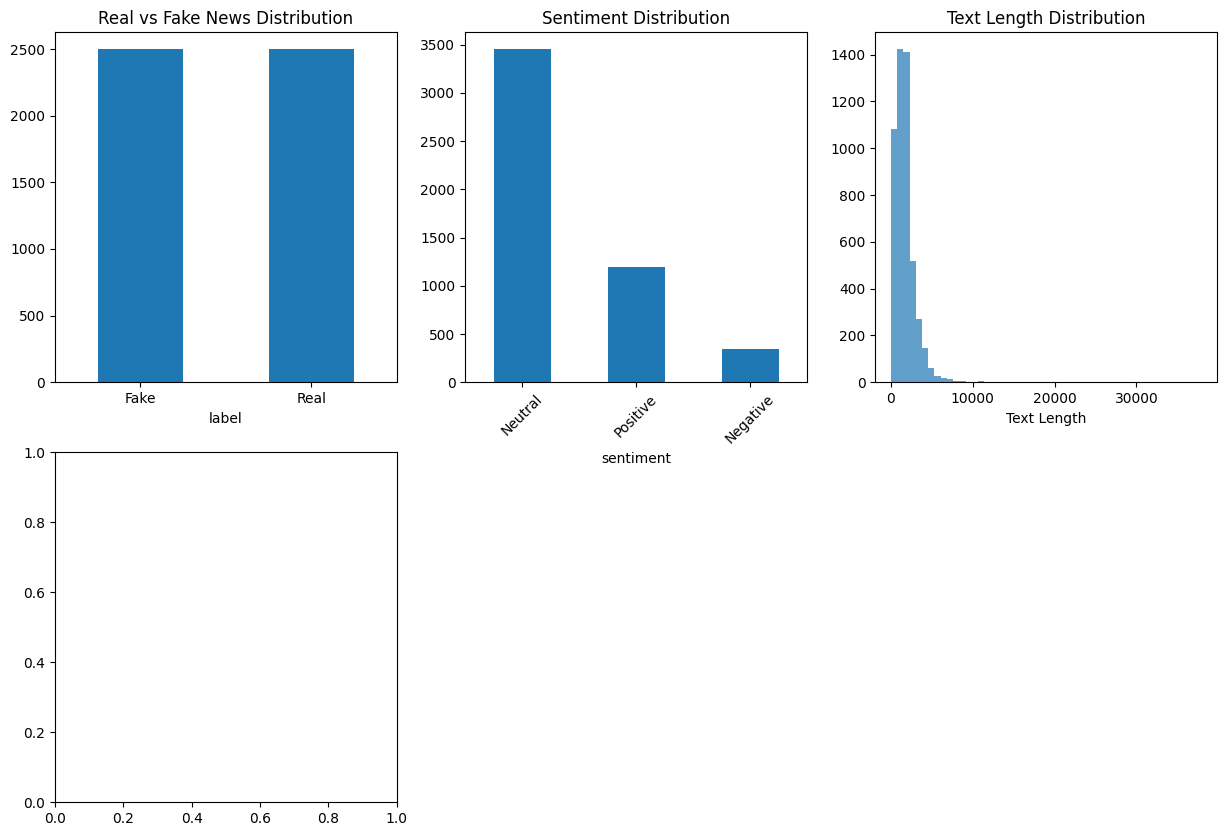

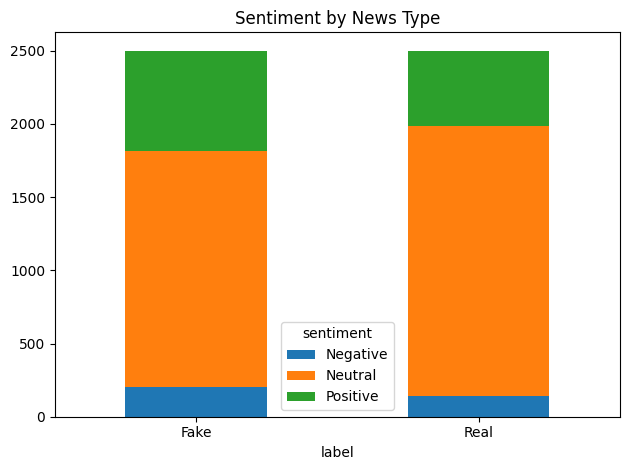

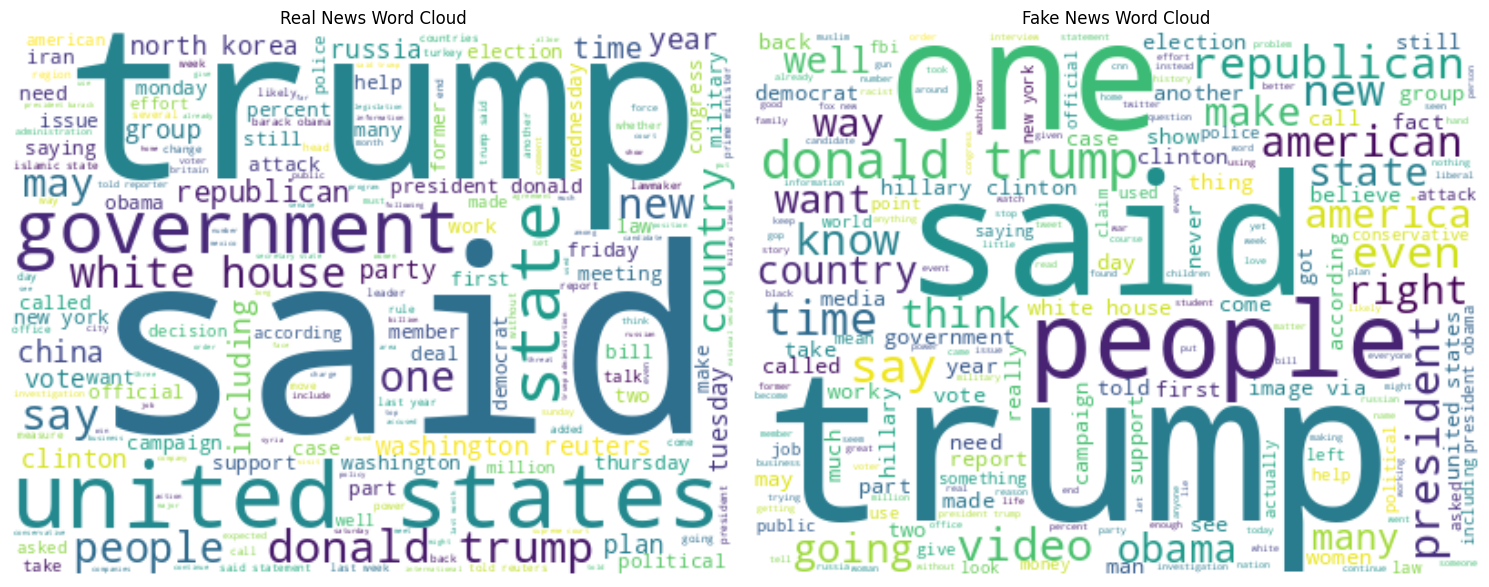

In [38]:
# ==============================
# 4. VISUALIZATIONS
# ==============================

def create_visualizations(data):
    """Create essential visualizations"""
    plt.figure(figsize=(15, 10))

    # 1. Label distribution
    plt.subplot(2, 3, 1)
    data['label'].value_counts().plot(kind='bar')
    plt.title('Real vs Fake News Distribution')
    plt.xticks([0, 1], ['Fake', 'Real'], rotation=0)

    # 2. Sentiment distribution
    plt.subplot(2, 3, 2)
    data['sentiment'].value_counts().plot(kind='bar')
    plt.title('Sentiment Distribution')
    plt.xticks(rotation=45)

    # 3. Text length distribution
    plt.subplot(2, 3, 3)
    data['text_length'] = data['processed_text'].str.len()
    plt.hist(data['text_length'], bins=50, alpha=0.7)
    plt.title('Text Length Distribution')
    plt.xlabel('Text Length')

    # 4. Sentiment by News Type
    plt.subplot(2, 3, 4)
    sentiment_cross = pd.crosstab(data['label'], data['sentiment'])
    sentiment_cross.plot(kind='bar', stacked=True)
    plt.title('Sentiment by News Type')
    plt.xticks([0, 1], ['Fake', 'Real'], rotation=0)

    plt.tight_layout()
    plt.show()

create_visualizations(data)

# Word clouds
def create_wordclouds(data):
    """Create word clouds for real and fake news"""
    plt.figure(figsize=(15, 6))

    # Real news wordcloud
    plt.subplot(1, 2, 1)
    real_text = ' '.join(data[data['label']==1]['processed_text'])
    wordcloud_real = WordCloud(width=400, height=300, background_color='white').generate(real_text)
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.title('Real News Word Cloud')
    plt.axis('off')

    # Fake news wordcloud
    plt.subplot(1, 2, 2)
    fake_text = ' '.join(data[data['label']==0]['processed_text'])
    wordcloud_fake = WordCloud(width=400, height=300, background_color='white').generate(fake_text)
    plt.imshow(wordcloud_fake, interpolation='bilinear')
    plt.title('Fake News Word Cloud')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

create_wordclouds(data)

In [39]:
# ==============================
# 5. PREPARE DATA FOR MODELING
# ==============================

X = data['processed_text']
y = data['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 4000
Test set size: 1000


In [40]:
# ==============================
# 6. CLASSICAL ML MODELS
# ==============================

# TF-IDF Vectorization with ML models
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Define models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True)
}

results = {}

print("Training Classical ML Models...")
for name, model in models.items():
    print(f"Training {name}...")

    # Create pipeline
    pipeline = Pipeline([
        ('tfidf', vectorizer),
        ('classifier', model)
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'accuracy': accuracy,
        'pipeline': pipeline,
        'predictions': y_pred
    }

    print(f"{name} Accuracy: {accuracy:.4f}")

# Best classical model
best_classical = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nBest Classical Model: {best_classical[0]} with accuracy: {best_classical[1]['accuracy']:.4f}")


Training Classical ML Models...
Training Naive Bayes...
Naive Bayes Accuracy: 0.9460
Training Logistic Regression...
Logistic Regression Accuracy: 0.9700
Training SVM...
SVM Accuracy: 0.9810

Best Classical Model: SVM with accuracy: 0.9810


In [41]:
# ==============================
# 7. DEEP LEARNING MODEL (LSTM)
# ==============================

print("\nTraining LSTM Model...")

# Tokenization for deep learning
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Build LSTM model
lstm_model = Sequential([
    Embedding(10000, 100, input_length=max_length),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM
history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=5,  # Fast training
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    verbose=1
)

# Evaluate LSTM
lstm_pred = (lstm_model.predict(X_test_pad) > 0.5).astype(int).flatten()
lstm_accuracy = accuracy_score(y_test, lstm_pred)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")



Training LSTM Model...
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 596ms/step - accuracy: 0.7422 - loss: 0.4925 - val_accuracy: 0.9980 - val_loss: 0.0126
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 539ms/step - accuracy: 0.9983 - loss: 0.0103 - val_accuracy: 0.9980 - val_loss: 0.0135
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 455ms/step - accuracy: 0.9989 - loss: 0.0050 - val_accuracy: 0.9980 - val_loss: 0.0148
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 409ms/step - accuracy: 0.9998 - loss: 0.0035 - val_accuracy: 0.9980 - val_loss: 0.0165
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 404ms/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 0.9980 - val_loss: 0.0199
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step
LSTM Accuracy: 0.9980

Using Pre-trained BERT for Classification...


TypeError: 'Pipeline' object is not callable

In [42]:
# ==============================
# 8. TRANSFORMER MODEL (BERT)
# ==============================

print("\nUsing Pre-trained BERT for Classification...")

# Hugging Face pipeline (avoid sklearn conflict)
from transformers import pipeline as hf_pipeline

# Create sentiment pipeline
sentiment_pipeline = hf_pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

# Sample a subset for faster processing
sample_size = min(1000, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_test_sample = X_test.iloc[sample_indices]
y_test_sample = y_test.iloc[sample_indices]

# Simplified fake news prediction using sentiment + keywords
def bert_like_prediction(texts):
    predictions = []
    fake_keywords = ['breaking', 'urgent', 'leaked', 'secret', 'exposed', 'shocking']

    for text in texts:
        sentiment_result = sentiment_pipeline(text[:512])[0]
        fake_score = sum([1 for kw in fake_keywords if kw in text.lower()])

        if sentiment_result['label'] in ['LABEL_2', 'NEGATIVE'] and fake_score > 1:
            predictions.append(0)  # Fake
        else:
            predictions.append(1)  # Real

    return np.array(predictions)

print("Processing with transformer approach...")
transformer_pred = bert_like_prediction(X_test_sample.tolist())
transformer_accuracy = accuracy_score(y_test_sample, transformer_pred)
print(f"Transformer-like Accuracy: {transformer_accuracy:.4f}")




Using Pre-trained BERT for Classification...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Processing with transformer approach...
Transformer-like Accuracy: 0.5000


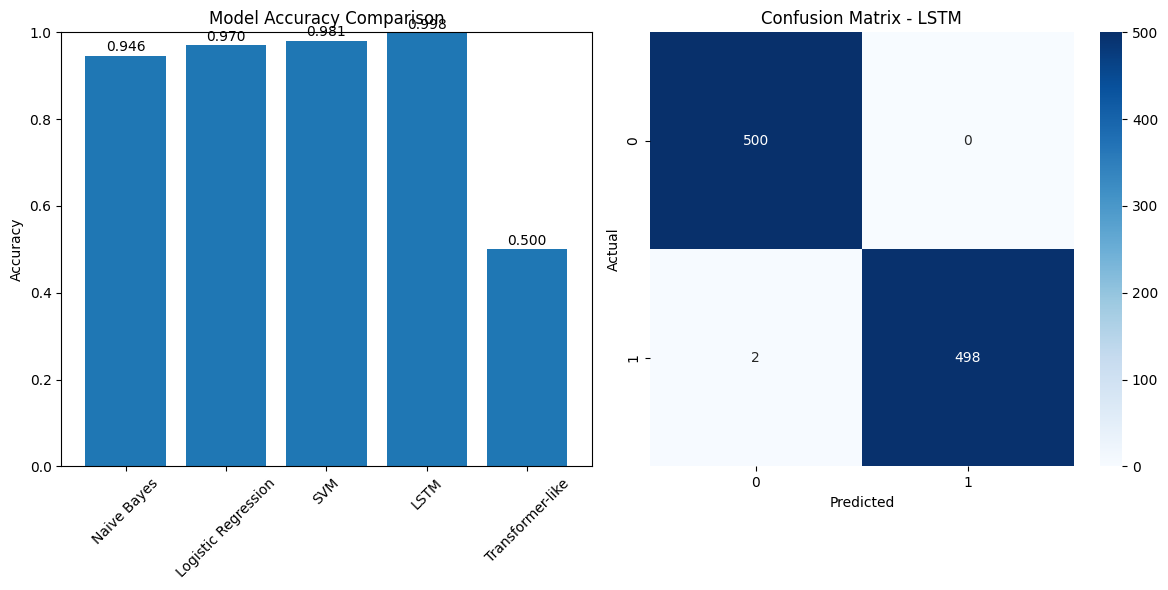

In [43]:
# ==============================
# 9. MODEL COMPARISON & RESULTS
# ==============================

# Create comparison
final_results = {
    'Naive Bayes': results['Naive Bayes']['accuracy'],
    'Logistic Regression': results['Logistic Regression']['accuracy'],
    'SVM': results['SVM']['accuracy'],
    'LSTM': lstm_accuracy,
    'Transformer-like': transformer_accuracy
}

# Plot comparison
plt.figure(figsize=(12, 6))
models_names = list(final_results.keys())
accuracies = list(final_results.values())

plt.subplot(1, 2, 1)
plt.bar(models_names, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add accuracy values on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# Confusion matrix for best model
plt.subplot(1, 2, 2)
best_model_name = max(final_results.items(), key=lambda x: x[1])[0]
if best_model_name in results:
    best_predictions = results[best_model_name]['predictions']
elif best_model_name == 'LSTM':
    best_predictions = lstm_pred
else:
    best_predictions = transformer_pred

cm = confusion_matrix(y_test if best_model_name != 'Transformer-like' else y_test_sample, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

In [44]:

# ==============================
# 10. SIMPLE DEPLOYMENT FUNCTION
# ==============================

def predict_news(text, model_pipeline=None, lstm_model=None, tokenizer=None):
    """
    Predict if news is fake or real and get sentiment
    """
    if model_pipeline is None:
        model_pipeline = best_classical[1]['pipeline']

    # Preprocess text
    processed = preprocess_text(text)

    # Get prediction
    prediction = model_pipeline.predict([processed])[0]
    probability = model_pipeline.predict_proba([processed])[0]

    # Get sentiment
    sentiment = get_sentiment(processed)

    result = {
        'text': text,
        'prediction': 'Real' if prediction == 1 else 'Fake',
        'confidence': max(probability),
        'sentiment': sentiment,
        'processed_text': processed
    }

    return result

# Test the function
test_news = "Breaking: Scientists discover new planet that could support life!"
result = predict_news(test_news)
print("\n" + "="*50)
print("PREDICTION TEST")
print("="*50)
print(f"Text: {result['text']}")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.3f}")
print(f"Sentiment: {result['sentiment']}")



PREDICTION TEST
Text: Breaking: Scientists discover new planet that could support life!
Prediction: Fake
Confidence: 0.999
Sentiment: Positive


In [45]:
# ==============================
# 11. SUMMARY REPORT DATA
# ==============================

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Dataset size: {data.shape[0]:,} articles")
print(f"Real news: {sum(data['label']):,} articles")
print(f"Fake news: {len(data) - sum(data['label']):,} articles")
print("\nModel Performance:")
for model, acc in final_results.items():
    print(f"  {model:<20}: {acc:.4f}")

print(f"\nBest Model: {max(final_results.items(), key=lambda x: x[1])[0]}")
print(f"Best Accuracy: {max(final_results.values()):.4f}")

print("\nSentiment Distribution:")
sentiment_dist = data['sentiment'].value_counts(normalize=True)
for sentiment, percentage in sentiment_dist.items():
    print(f"  {sentiment:<10}: {percentage:.3f}")

print("\n" + "="*60)
print("PIPELINE COMPLETE!")
print("="*60)


FINAL RESULTS SUMMARY
Dataset size: 5,000 articles
Real news: 2,500 articles
Fake news: 2,500 articles

Model Performance:
  Naive Bayes         : 0.9460
  Logistic Regression : 0.9700
  SVM                 : 0.9810
  LSTM                : 0.9980
  Transformer-like    : 0.5000

Best Model: LSTM
Best Accuracy: 0.9980

Sentiment Distribution:
  Neutral   : 0.691
  Positive  : 0.239
  Negative  : 0.070

PIPELINE COMPLETE!
